# Performance of Conventional and Non-Conventional Algorithmic Trading Strategies in Cryptocurrency Market

# Deep Learning for Market Movement Prediction

Neural networks are state-of-the-art in computer science. They are essentially trainable algorithms. They can find hidden patterns in the available data and can use these patterns to make accurate predictions.

In this notebook, we try to predict future market movements using a vanilla deep neural network.

# Setup

In [1]:
import numpy as np

import pandas as pd

import tensorflow as tf 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense 
from tensorflow.keras.optimizers import Adam, RMSprop

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_theme(style="darkgrid")

# Read the data from local drive

In [2]:
data = pd.HDFStore('data/BitcoinPriceData.h5', 'r')

dataNN = data['BitcoinPriceData']

data.close()

print(dataNN.info())
print('-'*20)
print('-'*20)
print(dataNN.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1980 entries, 2016-01-01 to 2021-06-02
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   1980 non-null   float64
dtypes: float64(1)
memory usage: 30.9 KB
None
--------------------
--------------------
               Value
Date                
2021-05-29  35689.62
2021-05-30  34647.67
2021-05-31  35684.59
2021-06-01  37310.54
2021-06-02  36662.64


In [3]:
dataNN.rename(columns={'Value':'price'}, inplace=True)

# Vanilla Neural Network

In [4]:
# Returns (log scale).
dataNN['returns'] = np.log(dataNN['price'] / dataNN['price'].shift(1))

dataNN.dropna(inplace=True)

In [5]:
# Preferred position.
dataNN['direction'] = np.where(dataNN['returns'] > 0, 1, 0)

In [6]:
# Last 'lags' days returns (log scale).
lags = 7

cols = []  # List of feature names. 
for lag in range(1, lags + 1): 
  col = f'lag_{lag}'
  dataNN[col] = dataNN['returns'].shift(lag) 
  cols.append(col)

dataNN.dropna(inplace=True)

dataNN.tail()

,price,returns,direction,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
Date,,,,,,,,,,
2021-05-29,35689.62,-0.074376,0,-0.021124,0.022029,-0.008247,0.108268,-0.076785,0.006629,-0.089831
2021-05-30,34647.67,-0.029629,0,-0.074376,-0.021124,0.022029,-0.008247,0.108268,-0.076785,0.006629
2021-05-31,35684.59,0.029488,1,-0.029629,-0.074376,-0.021124,0.022029,-0.008247,0.108268,-0.076785
2021-06-01,37310.54,0.044557,1,0.029488,-0.029629,-0.074376,-0.021124,0.022029,-0.008247,0.108268
2021-06-02,36662.64,-0.017518,0,0.044557,0.029488,-0.029629,-0.074376,-0.021124,0.022029,-0.008247


In [7]:
# Some other useful features.
# Momentum measure.
dataNN['momentum'] = dataNN['returns'].rolling(7).mean().shift(1)
# Volatility measure.
dataNN['volatility'] = dataNN['returns'].rolling(21).std().shift(1)
# Deviation measure.
dataNN['distance'] = (dataNN['price'] - dataNN['price'].rolling(21).mean()).shift(1)

dataNN.dropna(inplace=True)

dataNN.head()

,price,returns,direction,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,momentum,volatility,distance
Date,,,,,,,,,,,,,
2016-01-30,378.18,0.002436,1,-0.013637,-0.023822,-0.006261,0.017998,0.005180,-0.008816,0.007233,-0.003161,0.044589,-28.463810
2016-01-31,376.86,-0.003497,0,0.002436,-0.013637,-0.023822,-0.006261,0.017998,0.005180,-0.008816,-0.003846,0.044411,-23.998095
2016-02-01,372.00,-0.012980,0,-0.003497,0.002436,-0.013637,-0.023822,-0.006261,0.017998,0.005180,-0.003086,0.044405,-22.014286
2016-02-02,371.99,-0.000027,0,-0.012980,-0.003497,0.002436,-0.013637,-0.023822,-0.006261,0.017998,-0.005680,0.044356,-23.297619
2016-02-03,368.38,-0.009752,0,-0.000027,-0.012980,-0.003497,0.002436,-0.013637,-0.023822,-0.006261,-0.008255,0.044334,-19.689048


In [8]:
# Update the list of feature names.
cols.extend(['momentum', 'volatility', 'distance'])

In [9]:
def set_seeds(seed=100): 
  np.random.seed(seed) 
  tf.random.set_seed(100)

# Set the random seed.
set_seeds()

In [10]:
# Divide the dataset into training and test dataset.
cutoff = '2021-04-01'

# Training data.
training_data = dataNN[dataNN.index < cutoff].copy()

# Calculate the mean and std of feature values from instances in the training dataset.
mu, std = training_data.mean(), training_data.std()

# Normalize the training data.
training_data_ = (training_data - mu) / std

In [11]:
# Recalculate the preferred position.
training_data_['direction'] = np.where(training_data_['returns'] > 0, 1, 0)

In [12]:
# Test data.
test_data = dataNN[dataNN.index >= cutoff].copy()

# Normalize the test data.
test_data_ = (test_data - mu) / std

# Recalculate the preferred position.
test_data_['direction'] = np.where(test_data_['returns'] > 0, 1, 0)

In [13]:
# Model architecture.
model = Sequential() 
model.add(Dense(64, activation='elu', kernel_initializer="he_normal", input_shape=(len(cols),)))
model.add(Dense(64, activation='elu', kernel_initializer="he_normal")) 
model.add(Dense(64, activation='elu', kernel_initializer="he_normal"))
model.add(Dense(64, activation='elu', kernel_initializer="he_normal"))
model.add(Dense(64, activation='elu', kernel_initializer="he_normal"))
model.add(Dense(1, activation='sigmoid')) 

In [14]:
# Optimizer.
optimizer = Adam(learning_rate = 0.0001)

# Build the model.
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
# Early stopping.
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

In [16]:
# Fraction of training data to be used as validation data.
val_split = 0.2

# Fit the model.
history = model.fit(training_data_[cols], training_data_['direction'], 
          epochs=200, 
          validation_split=val_split,
          callbacks=[early_stopping_cb],
          verbose=False,
          shuffle=False)

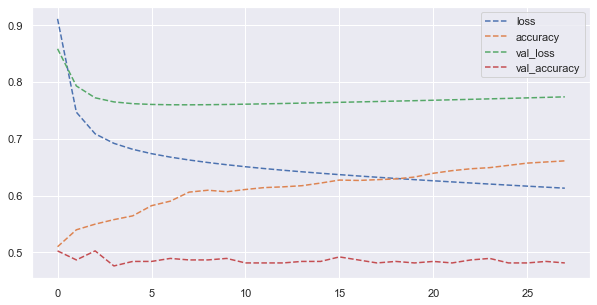

In [17]:
# Training characteristics.
res = pd.DataFrame(history.history)

# Plot the training characteristics.
res.plot(figsize=(10, 5), style='--');

In [18]:
# Evaluate the model on test data.
model.evaluate(test_data_[cols], test_data_['direction'])

2/2 [==============================] - 0s 11ms/step - loss: 0.6877 - accuracy: 0.6349


[0.6876655220985413, 0.6349206566810608]

In [19]:
# Predicted preferred position.
test_data['prediction'] = np.where(model.predict(test_data_[cols]) > 0.5, 1, -1)

In [20]:
# Strategy based returns (log scale).
test_data['strategy'] = test_data['prediction'] * test_data['returns']

In [21]:
# Final returns based on the passive benchmark investment and strategy (regular scale).
returns = test_data[['returns', 'strategy']].sum().apply(np.exp)

returns

returns     0.624256
strategy    2.588650
dtype: float64

In [22]:
# Cumulative returns over time based on the passive benchmark investment and strategy (regular scale).
gross_performance_nn = test_data[['returns', 'strategy']].cumsum().apply(np.exp) 

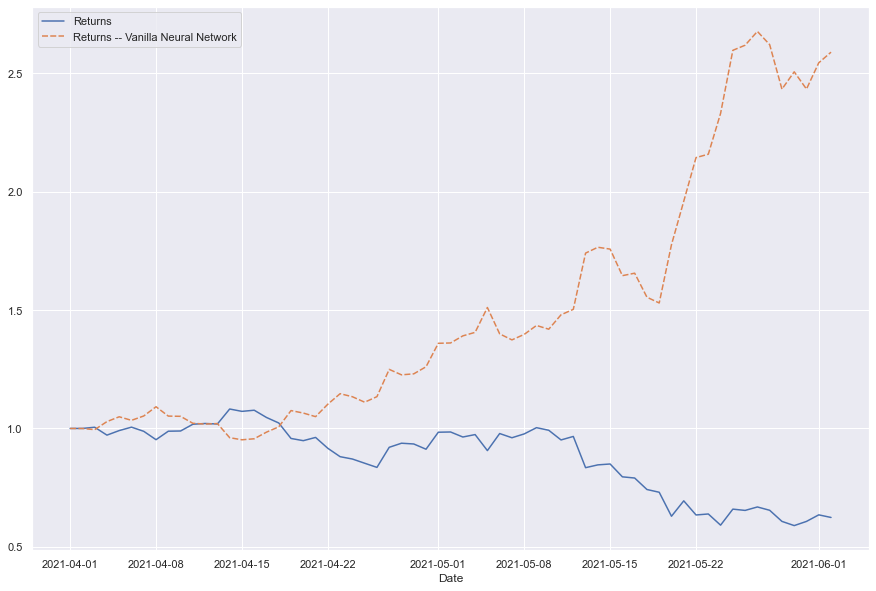

In [23]:
# Plot of cumulative returns based on the passive benchmark investment and strategy over time (regular scale).
plt.figure(figsize=(15, 10))
ax = sns.lineplot(data=gross_performance_nn, legend=False)
ax.legend(['Returns', 'Returns -- Vanilla Neural Network'])
plt.show()

## Summary

Predicting future market movements is the holy grail in finance. It means overcoming efficient markets. Due to the massive success of trainable algorithms, more and more traders are developing algorithms that rely on deep learning to make themselves more profitable.

### References

N/A